## Setup

In [37]:
import os
from dotenv import load_dotenv
from langchain_openai import ChatOpenAI,  OpenAIEmbeddings
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, List
from typing import Optional
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_chroma import Chroma



load_dotenv()

OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")

chatgpt = ChatOpenAI(model="gpt-4o")

## Basic RAG

In [9]:
test_docs = [
    Document(
        page_content="A red dog walking on a street.",
        metadata={},
    ),
    Document(
        page_content="A blue handbag floating in the sky.",
        metadata={},
    ),
    Document(
        page_content="A beautiful sunset at the end of a road.",
        metadata={},
    ),
    Document(
        page_content="No more eggs in the fridge",
        metadata={},
    )
]

In [10]:
vectorstore = Chroma.from_documents(
    documents=test_docs,
    collection_name="rag-chroma",
    embedding=OpenAIEmbeddings(),
)

retriever = vectorstore.as_retriever(search_type="similarity", k=3)

In [11]:
rag_prompt = ChatPromptTemplate.from_messages([
        ("system", """Use the following information to answer the question.
        {context}
        """),
        ("human", "{question}")
    ])

In [12]:
class State(TypedDict):
    question: str
    context: List[Document]
    answer: str

In [13]:
# nodes
def retrieve(state: State):
    print("retrieving documents")
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

def generate(state: State):
    print("generating response")
    docs_content = "\n\n".join(doc.page_content for doc in state["context"])
    messages = rag_prompt.invoke({"question": state["question"], "context": docs_content})
    response = chatgpt.invoke(messages)
    return {"answer": response.content}

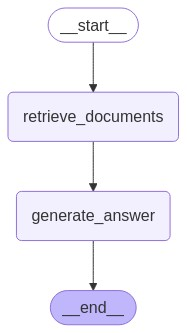

In [14]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("retrieve_documents", retrieve)
workflow.add_node("generate_answer", generate)

# Connect nodes
workflow.add_edge(START, "retrieve_documents")
workflow.add_edge("retrieve_documents", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [15]:
state = graph.invoke({"question": "how many eggs in the fridge?"})

retrieving documents
generating response


In [16]:
print(state['context'])
print(state['answer'])

[Document(id='70b8ff6b-ec31-466b-8dc5-6ebc8db6aa28', page_content='No more eggs in the fridge'), Document(id='a5bba28e-f339-4c0d-8ee4-18c486949bde', page_content='A blue handbag floating in the sky.'), Document(id='1524e723-a90f-4cd2-aea1-3d77c86c186d', page_content='A beautiful sunset at the end of a road.'), Document(id='85e20aff-b39e-47e5-99d0-36d64457f370', page_content='A red dog walking on a street.')]
There are no eggs in the fridge.


## Grading

In [17]:
# Grader prompt
doc_grader_prompt = """
You are a grader assessing relevance of a retrieved document to a user question.
Don't be too strict, this is more of a rough filtering process.
If the document contains keyword(s) or semantic meaning related to the question, grade it as relevant.
If the document is even loosely or metaphorically related, grade it as relevant.
Here is the retrieved document: \n\n {document} \n\n Here is the user question: \n\n {question}. 
"""

# This prompt might need to be adapted
# DEFINITELY TEST, sometimes the grader is much too strict

In [18]:
class State(TypedDict):
    question: str
    context: List[Document]
    filtered_context: List[Document]
    answer: str

In [19]:
class Feedback(BaseModel):
    grade: Literal["yes", "no"] = Field(
        description="Decide if the document is relevant to the question. Answer Yes or No."
    )
    reason: str = Field(
        description="Explain why the document is not relevant to the question"
    )

In [20]:
# Augment the LLM with schema
evaluator = chatgpt.with_structured_output(Feedback)

In [21]:
# nodes
def retrieve(state: State):
    print("retrieving documents")
    retrieved_docs = retriever.invoke(state["question"])
    return {"context": retrieved_docs}

def grade_documents(state: State):
    print("grading documents")
    filtered_docs = []

    for doc in state["context"]:
        doc_grader_prompt_formatted = doc_grader_prompt.format(
            document=doc.page_content, question=state["question"]
        )
        # print(f"formatted prompt: {doc_grader_prompt_formatted}")

        output = evaluator.invoke(doc_grader_prompt_formatted)
        print(f"grader answered: {output.grade}")

        if output.grade.lower() == "yes":
            filtered_docs.append(doc)
            print(output.reason)
        else:
            print(f"Removed doc with content: {doc.page_content}")
            print(output.reason)

    return {"filtered_context": filtered_docs}

def generate(state: State):
    print("generating response")
    filtered_docs_content = "\n\n".join(doc.page_content for doc in state["filtered_context"])
    messages = rag_prompt.invoke({"question": state["question"], "context": filtered_docs_content})
    response = chatgpt.invoke(messages)
    return {"answer": response.content}

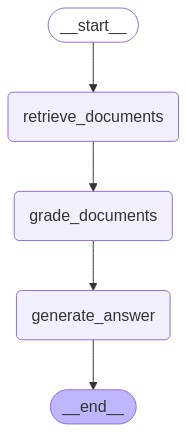

In [22]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("retrieve_documents", retrieve)
workflow.add_node("grade_documents", grade_documents)
workflow.add_node("generate_answer", generate)

# Connect nodes
workflow.add_edge(START, "retrieve_documents")
workflow.add_edge("retrieve_documents", "grade_documents")
workflow.add_edge("grade_documents", "generate_answer")
workflow.add_edge("generate_answer", END)

# Compile
graph = workflow.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [23]:
state = graph.invoke({"question": "where is the handbag?"})

retrieving documents
grading documents
grader answered: yes
The document metaphorically describes the handbag floating in the sky, which loosely answers the question about the handbag's location.
grader answered: no
Removed doc with content: A red dog walking on a street.
The document describes a scene with a red dog walking on a street and does not mention anything about a handbag or provide any information related to the location of a handbag.
grader answered: no
Removed doc with content: A beautiful sunset at the end of a road.
The document describes a sunset, which does not contain any keywords or semantic meaning related to the location of a handbag. There is no metaphorical or loose connection between the sunset and the question about a handbag's location.
grader answered: no
Removed doc with content: No more eggs in the fridge
The document 'No more eggs in the fridge' does not contain any keywords or semantic meaning related to the question 'where is the handbag?'. There is no c

In [24]:
print(state['context'])
print(state["filtered_context"])
print(state['answer'])

[Document(id='a5bba28e-f339-4c0d-8ee4-18c486949bde', page_content='A blue handbag floating in the sky.'), Document(id='85e20aff-b39e-47e5-99d0-36d64457f370', page_content='A red dog walking on a street.'), Document(id='1524e723-a90f-4cd2-aea1-3d77c86c186d', page_content='A beautiful sunset at the end of a road.'), Document(id='70b8ff6b-ec31-466b-8dc5-6ebc8db6aa28', page_content='No more eggs in the fridge')]
[Document(id='a5bba28e-f339-4c0d-8ee4-18c486949bde', page_content='A blue handbag floating in the sky.')]
The handbag is floating in the sky.


## Split Answer for Texting

In [51]:
#Graph State
class State(TypedDict):
    question: str
    answer: str
    answer_split: Optional[List[str]]


In [52]:
class SplitAnswer(BaseModel):
    parts: List[str] = Field(
        description= 
            "The answer, split into multiple short messages for texting. "
            "Split only if it improves the natural flow. "
            "If the answer should stay as one message, return a list with just that one string."
    )

In [53]:
splitter = chatgpt.with_structured_output(SplitAnswer)

In [54]:
prompt = ChatPromptTemplate.from_messages([
        ("system", """
You are a friendly assistant that responds via SMS or instant message.

Generate a natural-sounding reply to the user's question. Write casually, like a human texting — short, relaxed, and conversational. You can use emojis where they add emotion, emphasis, or rhythm, but only if they feel natural.

Sometimes a short reply or even just an emoji is best (e.g., "👀", "lol", "sure 🙃"). Avoid sounding robotic or overly formal.

Do not overuse emojis, and avoid always placing them at the end.
        """),
        ("human", "{question}")
    ])

splitter_prompt = ChatPromptTemplate.from_messages([
    ("system", """
You are helping format an AI-generated answer to be sent over SMS or chat. In order to make the message feel conversational and natural, consider breaking it into multiple shorter messages, like a human might do.

Split the message **only if it improves the rhythm or tone** — for example, to add a natural pause, build anticipation, or make it feel more casual and friendly. Do *not* split just because the message is long.

If the answer works best as a single message, return it unchanged as a single item in a list.

Here is the generated answer:
    
{answer}
""")
])

In [55]:
def generate(state: State):
    print("generating response")
    messages = prompt.invoke({"question": state["question"]})
    response = chatgpt.invoke(messages)
    return {"answer": response.content}

def split_answer(state: State):
    print("Trying to split answer")
    prompt_text = splitter_prompt.format(answer=state["answer"])
    result = splitter.invoke(prompt_text)
    return {"answer_split": result.parts}

In [63]:
# Build workflow
workflow = StateGraph(State)

# Add nodes
workflow.add_node("generate_answer", generate)
workflow.add_node("split_answer", split_answer)

# Connect nodes
workflow.add_edge(START, "generate_answer")
workflow.add_edge("generate_answer", "split_answer")
workflow.add_edge("split_answer", END)

# Compile
graph = workflow.compile()

print(graph.get_graph().draw_mermaid())
# Image(graph.get_graph().draw_mermaid_png())

%%{init: {'flowchart': {'curve': 'linear'}}}%%
graph TD;
	__start__([<p>__start__</p>]):::first
	generate_answer(generate_answer)
	split_answer(split_answer)
	__end__([<p>__end__</p>]):::last
	__start__ --> generate_answer;
	generate_answer --> split_answer;
	split_answer --> __end__;
	classDef default fill:#f2f0ff,line-height:1.2
	classDef first fill-opacity:0
	classDef last fill:#bfb6fc



In [57]:
state = graph.invoke({"question": "how many eggs in your fridge (metaphorically)?"})
print(state['answer'])

generating response
Trying to split answer
Haha, metaphorically speaking, I’d say I’ve got a full carton ready to scramble up some ideas! 🥚✨ What about you?


In [58]:
print(state['answer_split'])

['Haha, metaphorically speaking, I’d say I’ve got a full carton ready to scramble up some ideas! 🥚✨', 'What about you?']


## improve query

In [ ]:
def rewrite(state):
    """
    Transform the query to produce a better question.

    Args:
        state (messages): The current state

    Returns:
        dict: The updated state with re-phrased question
    """

    print("---TRANSFORM QUERY---")
    messages = state["messages"]
    question = messages[0].content

    msg = [
        HumanMessage(
            content=f""" \n 
    Look at the input and try to reason about the underlying semantic intent / meaning. \n 
    Here is the initial question:
    \n ------- \n
    {question} 
    \n ------- \n
    Formulate an improved question: """,
        )
    ]

    # Grader
    model = ChatOpenAI(temperature=0, model="gpt-4-0125-preview", streaming=True)
    response = model.invoke(msg)
    return {"messages": [response]}

## agentic retrieval

In [ ]:
from langchain.tools.retriever import create_retriever_tool

retriever_tool = create_retriever_tool(
    retriever,
    "retrieve_blog_posts",
    "Search and return information about Lilian Weng blog posts on LLM agents, prompt engineering, and adversarial attacks on LLMs.",
)

tools = [retriever_tool]